(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Clustering the data from the Mayor's 24-hour hotline in Boston

## Introduction 

In this assignment, we will do a clustering analysis on the 311 calls that we used in the previous homework. We will focus on choosing a value for k, clustering based on multiple features and detecting outliers.

---------------------------

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.preprocessing as process
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import numpy as np

In [2]:
boston = pd.read_csv('../Homework-2/cases_2015.csv')

## Step 1. Simple clustering

The first thing that we will try is to cluster the geolocation data of the calls. The geolocation of a record consists of a pair `(latitude, longitude)`, which represents the position of the record on the map. Since the dataset that we have spans only a small geographic location, i.e. Boston, we will use the Euclidean distance when measuring how close two points are. Techinically, we should pick a [projection](https://github.com/mbostock/d3/wiki/Geo-Projections) in order to transform the data into 2d, and measure  the Euclidean distance in the projected space.

Since we are dealing with numeric data, we might consider centering and normalizing them. In order to do that, check the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from `scikit-learn`.

For exampe, the result of a clustering with 10 clusters is the following:


![A clustering of the locations of the calls for k=10](clusters10.png)

Filter the dataset to get the latitude and longitude, transform it as required and run the k-means clustering algorithm. Argue about the number of clusters you used. **(pts 50)**

-----

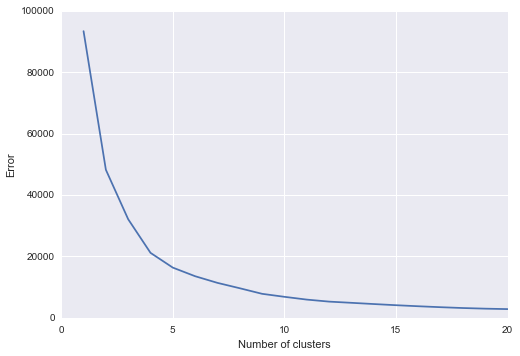

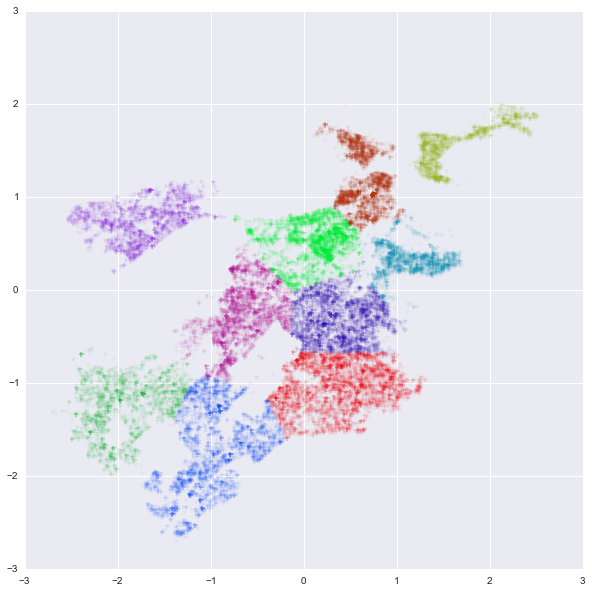

In [4]:
scalar = process.StandardScaler()
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)

geo = boston[['LATITUDE','LONGITUDE']]

#NOrmailizes the data
geo_norm = scalar.fit_transform(geo)
df_geo = pd.DataFrame(geo_norm)


#Gets the labels 
labels = kmeans.fit_predict(df_geo)
scaled_X= df_geo[1]
scaled_Y= df_geo[0]


#Taken from clutering notes
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(geo_norm,20)
#From the graph, the error appears to drop after about 10 clusters

#Taken from piazza @95
fig, ax = plt.subplots(1,1,figsize=(10,10))
cmap = sns.color_palette("bright", n_colors=4)
cmap.extend(sns.hls_palette(n_colors=6, h=0.7, l=0.4, s=0.8))

# for each label, isolate the points of that label and plot them with the same color
for i, label in enumerate(set(labels)):
    point_indices = np.where(labels == label)[0]
    point_indices = point_indices.tolist()
    plt.scatter(scaled_X[point_indices], scaled_Y[point_indices], s=25, alpha=0.2, c=cmap[i], marker='+')
    
"""
First the data was normalized to take out the mean and set the mean at 0. kmeans++ was then used to 
determine the number of clusters with the least error. According to the graph, 
the error drops around 10 clusters. The normalized data was then graphed with 10 clusters.
"""


## Step 2. Using multiple features

The next step in our analysis is to use more features than just the geolocation of a record (whose clustering only gives us information about the neighborhoods, which should not be a huge revelation!) Filter the dataset to get more features, transform them as required and compute another clustering. You should argue about the quality of your clustering and use domain knowledge (i.e. the fact that you are locals) to explore the clusters you produced and present them to the reader. **(pts 30)**

-----

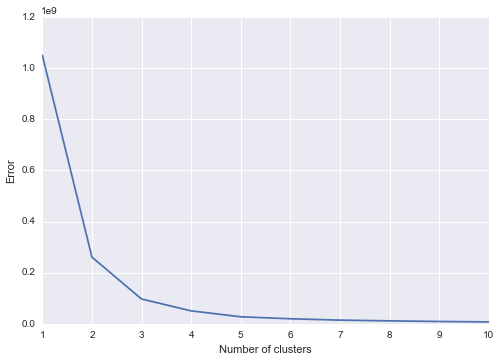

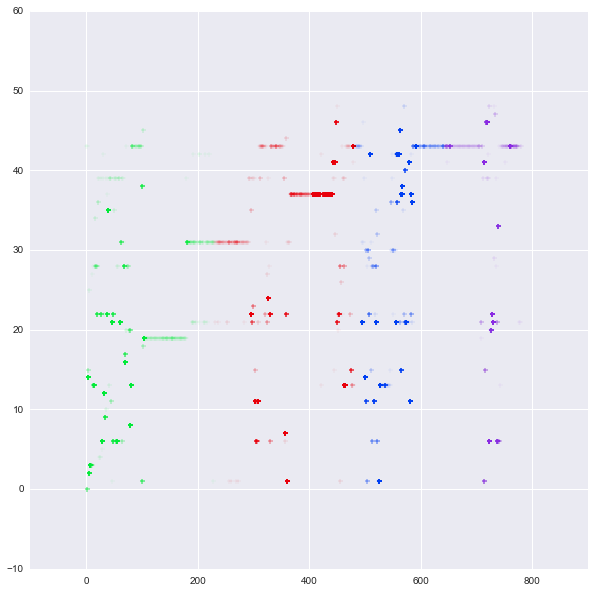

In [21]:
le = process.LabelEncoder()

t = boston[['CASE_TITLE','REASON']]
t = t.dropna(subset=['CASE_TITLE','REASON']).reset_index(drop=True)
reasons = t.REASON.values
case_array = t.CASE_TITLE.values


#Hashes the values for non-numeric values
hashed_reasons = le.fit(reasons)
hashed_reasons = le.transform(reasons)

hashed = le.fit(pre_array)
hashed = le.transform(case_array)


#Added new columns to original array to add the hashed values next to the original string for clarity
t['HASHED_CASE_TITLE'] = hashed
t['HASHED_REASON'] = hashed_reasons

#Rearranges the dataframe so that the hashed values are adjacent to the original string value
t = t[['CASE_TITLE','HASHED_CASE_TITLE','REASON','HASHED_REASON']]

new = zip(hashed,hashed_reasons)

kmeans2 = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans2.fit_predict(new)

f = pd.DataFrame(new)
evaluate_clusters(f,10)
#Error drops around 3 or 4 clusters, I decided to use 4 clusters in this case


labels2 = kmeans2.fit_predict(new)
scaled_X2= f[0]
scaled_Y2= f[1]

#Taken from piazza @95
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
cmap2 = sns.color_palette("bright", n_colors=4)
cmap2.extend(sns.hls_palette(n_colors=6, h=0.7, l=0.4, s=0.8))

for i, label in enumerate(set(labels2)):
    point_indices = np.where(labels2 == label)[0]
    point_indices = point_indices.tolist()
    plt.scatter(scaled_X2[point_indices], scaled_Y2[point_indices], s=25, alpha=0.2, c=cmap2[i], marker='+')


"""
The y-axis is "REASONS" while x-axis is "CASE_TITLE". Since both values are strings,
they were hashed to integers using the LabelEncoder. Although kind of uninteresting, it makes sense that "CASE_TITLE"s with 'street' in them would be grouped with "REASON"s that contain 'street' would be clustered together. Though, what would be interesting would 
be to see the CASE_TITLE "missing pb" and where that clusters, which is most likely an outlier. 
"""



#### Step 3. Detecting outliers

Now that we have a clustering of the records in the dataset, we can detect the outlying ones. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(pts 20)** 

In [76]:
#Grabs the center of each cluster
centers = kmeans2.cluster_centers_

print centers

#Finds the 'REASON' value for each center
c1 = t[t.HASHED_CASE_TITLE == 561] #Street cleaning
c2 = t[t.HASHED_CASE_TITLE == 57] #Notification 
c3 = t[t.HASHED_CASE_TITLE == 402] #Sanitation
c4 = t[t.HASHED_CASE_TITLE == 721] #Street cleaning

#Finds the maximum hashed CASE_TITLE of each cluster to find the outliers 
max_c1 = c1['HASHED_CASE_TITLE'].max() 
#Unhashed Output is 'Requests for Street Cleaning,' no outliers or anything strange for this center
c1_out = c1[c1.HASHED_CASE_TITLE == max_c1]

max_c2 = c2['HASHED_CASE_TITLE'].max() 
#Unhashed output is 'Electrical Safety: Person/Pet Shocked////printed' - which makes sense, 
#since the CASE_TITLE is strange/unique
c2_out = c2[c2.HASHED_CASE_TITLE == max_c2]

max_c3 = c3['HASHED_CASE_TITLE'].max() 
#Unhashed output is Missed Leaf or Yard Trash: District 1A, which is another strange/unique case title
c3_out = c3[c3.HASHED_CASE_TITLE == max_c3]


max_c4 = c4['HASHED_CASE_TITLE'].max() 
#Unhashed output is 'Uncleaniness Site,' which is also strange, considering 'Uncleaniness' isn't word..
c4_out = c4[c4.HASHED_CASE_TITLE == max_c4]


print
print c2_out.CASE_TITLE
print
print c3_out.CASE_TITLE
print
print c4_out.CASE_TITLE



[[ 561.20110069   32.52393841]
 [  57.00502092   17.54811715]
 [ 401.52269861   27.04905422]
 [ 721.208159     32.45188285]]

28628    Electrical Safety: Person/Pet Shocked////printed
Name: CASE_TITLE, dtype: object

4798    Missed Leaf or Yard Trash: District 1A
Name: CASE_TITLE, dtype: object

3598    Uncleaniness Site
Name: CASE_TITLE, dtype: object


In [9]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()

Collaborative Partners: Christine Tran, Beth Becker